# Emulate a Lorenz 96 model
The objective of this notebook is to provide a tutorial that emulates a Lorenz 63 model from data only.

The general objective of this work is to present a methodology that consider a time-series ${\bf v}_0,\cdots,{\bf v}_K$ and infer a data-driven model $G({\bf v}_k)$ that give samples from a posteriori distribution representing the uncertainty
$$
{\bf x}_{k+1} \sim p({\bf x}_{k+1}/{\bf x}_k)
$$
and more generally:
$$
{\bf x}_{k+1} \sim p({\bf x}_{k+1}/{\bf x}_0)
$$

## Importation and initializations
This section imports and define few utilities functions. You can execute the cells below and then goes directly to the part 1-data definition.

In [1]:
incolab=True
try:
  import colab
except:
  incolab = False

if incolab:
  print("This notebook runs under colab")
  !pip install wget
  import wget
  wget.download('https://raw.githubusercontent.com/nansencenter/ml-crashcourse/main/utils.py')

In [2]:
## Before we start let's import few packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import tensorflow.keras as keras
import properscoring as ps

import tensorflow as tf
from tensorflow.keras import layers
from utils import simulate, plot_L96_2D, dt, rmse, Periodic1DPadding
from utils import forward_L96 as forward
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
#import tensorflow_probability as tfp
from skimage.util import view_as_blocks


In [3]:
## We initialize the random generators so the notebook is fully reproducible

np.random.seed(2021)
tf.random.set_seed(2022)


1. Data definition

The Lorenz 96 model is defined on a 40-dimensional state $\mathbf{x}(t)$ by the following equations:
\begin{align}
\frac{\mathrm{d}x_i}{\mathrm{d}t} &= (x_{i+1} - x_{i-2})x_{i-1} + F,
\end{align}
In our case we take the defaults values $F = 8$


We integrate the ODEs (Ordinary Differential Equations) using a runge kutta scheme on discrete time steps $t_k$ such as $t_{k+1}-t_k = \delta t = 0.01$ (by default). We denote $\mathcal{M}$ the inegretion operator (sometimes called the *resolvent*) over a time step $\delta t$, such as:
$$
{\bf x_{k+1}} = \mathcal{M}({\bf x_{k}})
$$


Now we are almost ready to generate all the data. We are defining all the necessary parameters (some of which will be explained later on). 

In [4]:
M = 40 # size of the state
K = 50000 # size of the reference simulation
Ktrain=15000 # Number of samples in the training set
Kval = 10000 # Number of samples in the validation set
Ktest = 2000 # Number of samples in the test set (used to assess the forecast skill/uncertainty)
Ntest = 50 # Size of the test set ensemble
x0ref = np.zeros(M) # Reference point to initialize simulations
stdo = 0 #Relative noise on the data
Nens = 50 # Size of the ensemble for uncertainty estimate


Now, let's simulate the data for the reference set and the test set

In [5]:
#Reference dataset generation
x0 = x0ref + 1e-3*np.random.randn(M)
x = simulate(forward, K, x0)


# Define the noise field
sigma = np.std(x,axis=0)
noise = stdo*sigma*np.random.randn(K,M)

# Extract the training and validation set (add noise on the training)
Xtrain = x[0:Ktrain] +  noise[0:Ktrain]
ytrain = x[1:Ktrain+1] + noise[1:Ktrain+1]

Xval = x[Ktrain:Ktrain+Kval]
yval = x[Ktrain+1:Ktrain+Kval+1]
ttval = dt*(Ktrain+1)+ dt*np.arange(Kval)
# Test set (ensemble) generation
x0test = x0ref[np.newaxis,:] + 1e-3*np.random.randn(Ntest,M)
xtest = simulate(forward, Ktest, x0test, N=Ntest)
ttest = dt*np.arange(Ktest) #Time scale of the test datset

# Print the size
print(f'Size of the reference set: {x.shape}\nSize of the test set: {xtest.shape}')


Size of the reference set: (50000, 40)
Size of the test set: (2000, 50, 40)


We now plot the simulations of few time steps of one member of the test simulation

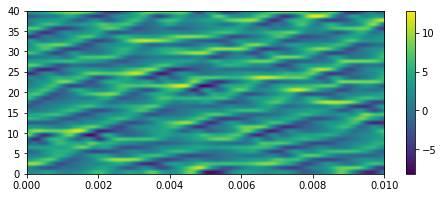

In [6]:
fig, ax = plt.subplots(figsize=(8,3))
cm = ax.imshow(xtest[:600,1].T,extent=[ttest[0],ttest[1],0,M],aspect='auto')
fig.colorbar(cm)

## 2. The neural network emulator
First, let's define the list of parameters for the neural network. 

In [7]:
stoch = True #To predict the standard deviation
norm_input = True #Standardization of the input vector
nhid1 = 60 # Number of filters in the first hidden layer
nhid2 = 40 # Number of filters in the second hiddent layer
filter1 = 5 # Filter size for the first layer
filter2 = 1 # Filter size of the second layer
epochs = 40 # Number of epochs during optimization
optimizer = 'Adam'# Optimizer used for the training
var = True

In [8]:
if var:
    scale_std = np.sqrt
    scale_var = lambda x:x
else:
    scale_std = lambda x:x
    scale_var = np.square

Compute the normalization of the input:

In [9]:
if norm_input:
    mean_ = np.mean(Xtrain,axis=(0,1),keepdims=True)
    std_= np.std(Xtrain,axis=(0,1), keepdims=True)
    norm = lambda x: (x-mean_)/std_
    denorm = lambda x: x*std_ + mean_
else:
    norm = lambda x: x
    denorm = lambda x: x

Define the deterministic neural network model



In [10]:
inputs = keras.Input(shape=(M,1))
border= (filter1//2+filter2//2)
lay = Periodic1DPadding(padding_size=border)(inputs)
lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
outputs = layers.Conv1D(1,1)(lay)
nn_model_det = keras.Model(inputs=inputs, outputs=outputs, name='deterministic_L96')
nn_model_det.compile(optimizer=optimizer, loss='mse')
nn_model_det.summary()

Model: "deterministic_L96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 1)]           0         
_________________________________________________________________
periodic1d_padding (Periodic (None, 44, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 60)            360       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 40)            2440      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 1)             41        
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_________________________________________________________________


2021-12-04 12:44:21.891726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<font color='blue'>

**Gaussian version (with mean and standard devation as output)**

We can interpret the loss function as a maximum of likelihood if we make the hypothosesis that the observationfollows a Gaussian law:

$$
p(y/x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp -\frac{(y - \mu(x))^2}{2\sigma^2}
$$
where $x$ is observed, and $\mu(x)$ represents the mean of the gaussian depending on $x$.
This is a general formula, expressed for simplicity in the scalar case. In our case, we have $x = {\bf x}_k$ and $y = {\bf x}_{k+1}$

Given a set of samples $(x_k,y_k)_{1:K}$, maximizing the likelihood (i.e. finding an estimation so that the observation is the more probable) consist in minimizing the negative log-likelihood:
$$
L = \sum_{k=1}^{K} \left(\frac{\log 2\pi\sigma^2}{2} + \frac{(y_k - \mu(x_k))^2}{2\sigma^2}\right)
$$

1. **Deterministic case**: $\mu(x) \approx G_\mu(x,{\boldsymbol \theta}_\mu)$ 
We try to identify the parameters of the neural net ${\boldsymbol \theta}_\mu$ that minimze L. As the first term and the denominator of L are a constant (do not depend on ${\boldsymbol \theta}_\mu$), we equivalentely minimize:
$$
L({\boldsymbol \theta}_\mu) =  \sum_{k=1}^{K} (y_k - G_\mu(x,{\boldsymbol \theta}_\mu))^2
$$
which is exactly the mean square loss already introduced.


2. **Gaussian case**: $\mu(x) \approx G_\mu(x_k,{\boldsymbol \theta}_\mu)$  and $\sigma(x) \approx \sqrt{G_\sigma(x,{\boldsymbol \theta}_\sigma)}$
We now assume that the standard deviation depends also on $x$ and that we parameterize it by another neural network.
So we can estimate both the parameters of the neural net for the mean $\mu$ and the standard deviation $\sigma$ by minimizing:
$$
L({\boldsymbol \theta}_\mu, {\boldsymbol \theta}_\sigma) = \sum_{k=1}^{K} \left(\frac{\log 2\pi G_\sigma(x_k,{\boldsymbol \theta}_\sigma)}{2} + \frac{(y_k - G_\mu(x_k,{\boldsymbol \theta}_\mu))^2}{2 G_\sigma(x_k,{\boldsymbol \theta}_\sigma)}\right)
$$
This way the neural net $G=(G_\mu,  G_\sigma)$ gives not only an estimation of the output but also the uncertainty of this estimation in the form of the standard deviation.
    </font>


In [11]:
def loss_mle_old(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    mean_true = y_true
    mean_pred, std_pred = y_pred[...,0], y_pred[...,1]
    # Max to prevent NaN's and Inf's
    log_std = tf.math.log(tf.maximum(std_pred,tf.math.sqrt(tf.keras.backend.epsilon())))
    sq_std = tf.maximum(tf.square(std_pred),tf.keras.backend.epsilon() )
    mse = tf.math.squared_difference(mean_pred, mean_true) / (2*sq_std)
    loss = log_std + mse
    loss = tf.reduce_sum(loss, -1)
    return loss

def loss_mle(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    mean_true = y_true
    mean_pred, var_pred = y_pred[...,0], tf.maximum(y_pred[...,1], tf.keras.backend.epsilon())
    # Max to prevent NaN's and Inf's
    log_std = tf.math.log(var_pred)
    mse = tf.math.squared_difference(mean_pred, mean_true) / var_pred
    loss = log_std + mse
    loss = tf.reduce_sum(loss, -1)
    return loss

def loss_mle_tfp(y_true, y_pred):
    mean_true = y_true
    mean_pred, std_pred = y_pred[...,0], y_pred[...,1]
    norm_dist = tfp.distributions.Normal(loc = mean_pred, scale = std_pred)
    loss = - norm_dist . log_prob ( y_true)
    loss = tf.reduce_mean(loss, -1)
    return loss

if stoch:
    inputs = keras.Input(shape=(M,1))
    border= (filter1//2+filter2//2)
    lay = Periodic1DPadding(padding_size=border)(inputs)
    lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
    lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
    mu = layers.Conv1D(1,1)(lay)
    var = layers.Conv1D(1,1, activation='exponential')(lay)
    outputs = layers.Concatenate(name='output')([mu, var])
    
    nn_model_gauss = keras.Model(inputs=inputs, outputs=outputs, name='gaussian_L96')
    nn_model_gauss.summary()
    #Need a special loss


    nn_model_gauss.compile(optimizer=optimizer, loss=loss_mle_tfp)




Model: "gaussian_L96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
periodic1d_padding_1 (Periodic1 (None, 44, 1)        0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 40, 60)       360         periodic1d_padding_1[0][0]       
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 40, 40)       2440        conv1d_3[0][0]                   
_______________________________________________________________________________________

It is now possible de train the model (optimize the parameters)

First we train the deterministic model


In [12]:
history_d = nn_model_det.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=epochs)


2021-12-04 12:44:31.214997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
469/469 [==============================] - 1s 2ms/step - loss: 1.1993 - val_loss: 0.1123
Epoch 2/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0822 - val_loss: 0.0614
Epoch 3/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0425 - val_loss: 0.0309
Epoch 4/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0208 - val_loss: 0.0145
Epoch 5/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 6/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/40
469/469 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 8.8346e-04
Epoch 8/40
469/469 [==============================] - 1s 2ms/step - loss: 6.6665e-04 - val_loss: 6.0059e-04
Epoch 9/40
469/469 [==============================] - 1s 2ms/step - loss: 4.7634e-04 - val_loss: 4.4638e-04
Epoch 10/40
469/469 [==============================] - 1s 2ms/step - loss: 3.686

Before assessing the performance of the NN model, we have look at the loss decreasing over the epochs for the training dataset and the validation dataset. 

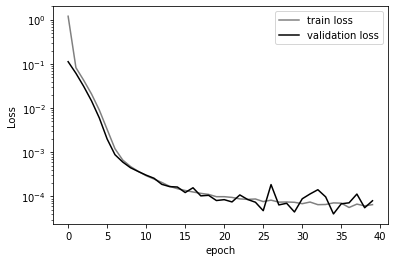

In [13]:
fig, ax = plt.subplots()
ax.semilogy(history_d.history['loss'],color='gray',label='train loss')
ax.semilogy(history_d.history['val_loss'],color='black',label='validation loss')
ax.legend()
ax.set_xlabel('epoch');
ax.set_ylabel('Loss');

<font color='blue'>
We now train the stochastic model</font>

Epoch 1/40
469/469 [==============================] - 1s 2ms/step - loss: 1.2603 - val_loss: -0.9939
Epoch 2/40
469/469 [==============================] - 1s 2ms/step - loss: -1.7594 - val_loss: 0.4166
Epoch 3/40
469/469 [==============================] - 1s 2ms/step - loss: -2.3581 - val_loss: -2.4064
Epoch 4/40
469/469 [==============================] - 1s 2ms/step - loss: -2.6180 - val_loss: -2.9006
Epoch 5/40
469/469 [==============================] - 1s 2ms/step - loss: -2.7189 - val_loss: -2.4464
Epoch 6/40
469/469 [==============================] - 1s 2ms/step - loss: -2.7745 - val_loss: -2.5902
Epoch 7/40
469/469 [==============================] - 1s 2ms/step - loss: -2.8952 - val_loss: -2.4114
Epoch 8/40
469/469 [==============================] - 1s 2ms/step - loss: -2.9874 - val_loss: -3.2978
Epoch 9/40
469/469 [==============================] - 1s 2ms/step - loss: -2.9640 - val_loss: -2.9312
Epoch 10/40
469/469 [==============================] - 1s 2ms/step - loss: -3.1378 -

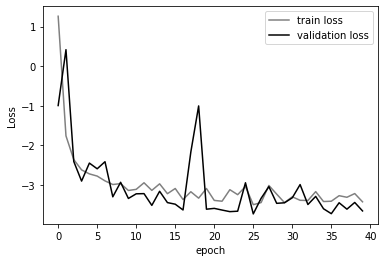

In [14]:
if stoch:
    import tensorflow_probability as tfp
    history_s = nn_model_gauss.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=epochs)
    fig, ax = plt.subplots()
    ax.plot(history_s.history['loss'],color='gray',label='train loss')
    ax.plot(history_s.history['val_loss'],color='black',label='validation loss')
    ax.legend()
    ax.set_xlabel('epoch');
    ax.set_ylabel('Loss');

Prediction of the model on the validation set:

In [15]:
ynn_det = nn_model_det.predict(norm(Xval))
if stoch:
    ynn_sto = nn_model_gauss.predict(norm(Xval))


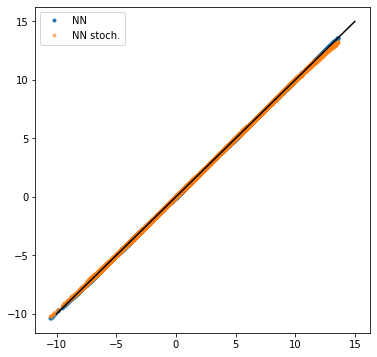

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(yval.ravel(),ynn_det[...,0].ravel(),'.', label='NN')

if stoch:
    ax.plot(yval.ravel(),ynn_sto[...,0].ravel(),'.', alpha=.5,label='NN stoch.')
    ax.legend()
ax.plot([-10,15],[-10,15],'-k');

In [17]:
# Calibrate the stochastic NN
obs_mean_err = np.mean(np.square(yval-ynn_sto[:,:,0]))
sim_mean_err = np.mean(np.square(ynn_sto[...,1]))
print(obs_mean_err,sim_mean_err)
calb = np.sqrt(obs_mean_err / sim_mean_err)
cal_mean_err = np.mean(np.square(calb*ynn_sto[...,1]))
print(obs_mean_err,cal_mean_err)
calb=1
print(calb)

0.00012994660245972372 8.722934e-05
0.00012994660245972372 0.00012994658
1


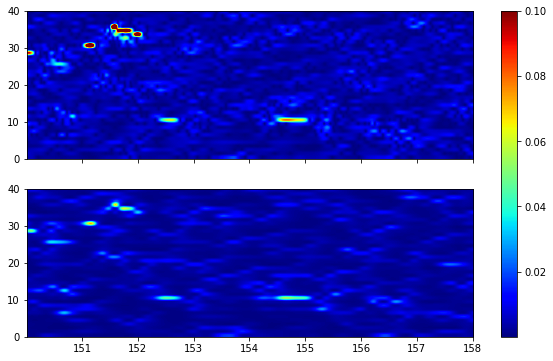

In [18]:
if stoch:
    Nt = 800

    fig, ax = plt.subplots(nrows=2,figsize=(10,6),sharex='all')
    d1 = ax[0].imshow(np.abs(yval[:Nt].T-ynn_sto[:Nt,:,0].T),extent=[ttval[0],ttval[Nt],0,M],aspect='auto',cmap='jet',vmax=.1)
    d2 = ax[1].imshow(calb*ynn_sto[:Nt,:,1].T,extent=[ttval[0],ttval[Nt],0,M],aspect='auto',cmap='jet',vmax=.1)
    fig.colorbar(d1, ax=ax, orientation='vertical');

Now we compare only one coordinate (15)

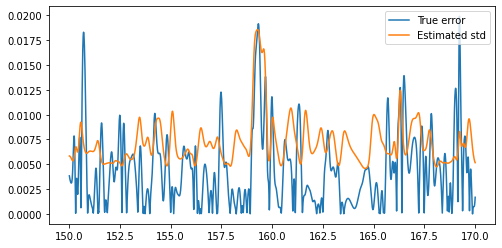

In [19]:
if stoch:
    Nt = 2000
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ttval[:Nt],np.abs(yval[:Nt,15]-ynn_sto[:Nt,15,0]), label='True error')
    ax.plot(ttval[:Nt],calb*ynn_sto[:Nt,15,1], label='Estimated std')
    ax.legend()
   

<font color='blue'>
The normalized distribution of the errors is expected to be a Gaussian of mean zero ans standard deviation. We can see there is still a bias.</font>


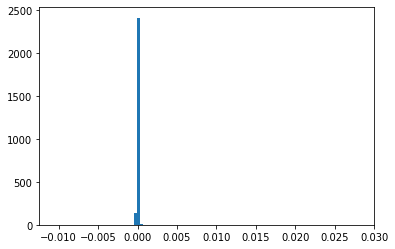

In [20]:
if stoch:
    delta = (yval[:Nt]-ynn_sto[:Nt,:,0])/calb*ynn_sto[:Nt,:,1]
    plt.hist(delta.ravel(),bins=100, density=True)
    xx = np.arange(-4,4,.01)
    #yy = 1/(np.sqrt(2 * np.pi)) * np.exp( - xx**2 / 2)
    #plt.plot(xx,yy)
    #plt.xlim((-4,4));


Define the resolvant of the NN nodel. We have 3 resolvants:
- The output of the determistic neural net ```forward_d```
- <font color='blue'> The average of the gaussian neural net: ```forward_sd```</font>
- <font color='blue'> The average of the  gaussian neural net perturbed by a random noise of with the standard deviation given by the
neural net: ```forward_ss```</font>

In [21]:
#Deterministic model: constant standard deviation
std_d = np.sqrt(np.mean(np.square(ynn_det.squeeze() - yval)))
print(std_d)

def forward_ds(v):
    epsi = np.random.randn(*v.shape)
    y = nn_model_det(norm(v), training=False)
    return y[...,0] + epsi*std_d

if stoch:
    def forward_ss(v):
        epsi = np.random.randn(*v.shape)
        y = nn_model_gauss(norm(v), training=False)
        return  y[...,0] + calb*epsi*np.sqrt(y[...,1])

0.008948416762669149


Duplicate the test ensemble

In [22]:
Xtest = np.repeat(xtest,Nens,axis=1)


Integrate the NN model over the test dataset and plot one trajectory


In [23]:

xtestnn_ds = simulate(forward_ds, Ktest, Xtest[0], M=M, N=Ntest*Nens,burnin=0)
xtestnn_ds = view_as_blocks(xtestnn_ds,(1,Nens,1)).squeeze()
if stoch:
    xtestnn_ss = simulate(forward_ss, Ktest, Xtest[0], M=M, N=Ntest*Nens,burnin=0)
    xtestnn_ss = view_as_blocks(xtestnn_ss,(1,Nens,1)).squeeze()

In [24]:
xtestnn_ds_mean = np.mean(xtestnn_ds,axis=-1)
xtestnn_ss_mean = np.mean(xtestnn_ss,axis=-1)


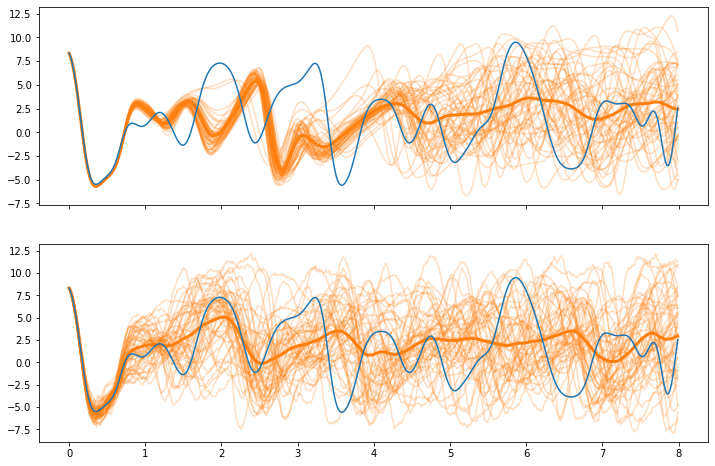

In [25]:
Nt=800
itest = 2

fig, ax = plt.subplots(nrows=2, figsize=(12,8),sharex=True)
ax[0].plot(ttest[:Nt],xtestnn_ds[:Nt,itest,15],color='C1',alpha=.25);
ax[0].plot(ttest[:Nt],xtestnn_ds_mean[:Nt,itest,15],color='C1',linewidth=3)
ax[0].plot(ttest[:Nt],xtest[:Nt,itest,15])
ax[1].plot(ttest[:Nt],xtestnn_ss[:Nt,itest,15],color='C1',alpha=.25);
ax[1].plot(ttest[:Nt],xtestnn_ss_mean[:Nt,itest,15],color='C1',linewidth=3)

ax[1].plot(ttest[:Nt],xtest[:Nt,itest,15])

Now we can plot the simulation of each of the simulations

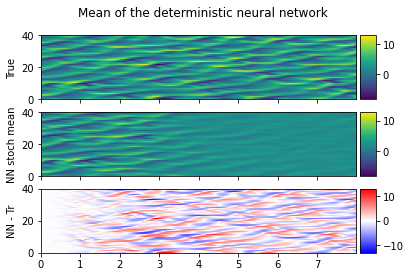

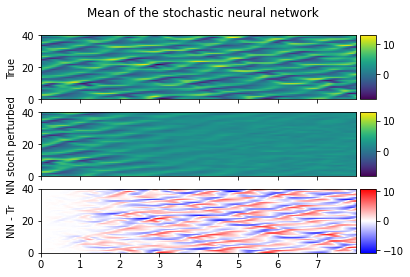

In [26]:


if stoch:
    fig, ax = plot_L96_2D(xtest[:800,1],xtestnn_ds_mean[:800,1],ttest[:800], ('True','NN stoch mean'))
    fig.suptitle('Mean of the deterministic neural network')

    fig, ax = plot_L96_2D(xtest[:800,1],xtestnn_ss_mean[:800,1],ttest[:800], ('True','NN stoch perturbed'))
    fig.suptitle('Mean of the stochastic neural network')



Now we can assess the forecast skill

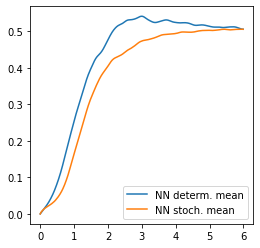

In [27]:
if stoch:
    rmse_nn_ds = rmse(xtest, xtestnn_ds_mean, axis=(1,2))
    rmse_nn_ss = rmse(xtest, xtestnn_ss_mean, axis=(1,2))

fig, ax = plt.subplots(figsize=(4,4))
if stoch:
    ax.plot(ttest[:600],rmse_nn_ds[:600], label= 'NN determ. mean')
    ax.plot(ttest[:600],rmse_nn_ss[:600], label= 'NN stoch. mean')

ax.legend();

In [28]:
xtestnn_ds.shape

(2000, 50, 40, 50)

In [29]:
crps_ds = ps.crps_ensemble(xtest[:600,:,25], xtestnn_ds[:600,:,25],axis=-1)
crps_ss = ps.crps_ensemble(xtest[:600,:,25], xtestnn_ss[:600,:,25],axis=-1)


In [30]:
crps_ds_mean = crps_ds.mean(axis=-1)
crps_ss_mean = crps_ss.mean(axis=-1)

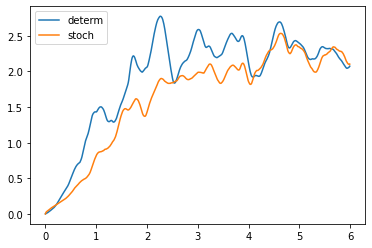

In [31]:
Nt=600
plt.plot(ttest[:Nt],crps_ds_mean[:Nt], label='determ')
plt.plot(ttest[:Nt],crps_ss_mean[:Nt], label='stoch')
plt.legend()

In [32]:
#TODO:
# - extremes
# - rank histograms at differents time